### 1D Burger Equation NFTM Simulator using a CNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader

#### Load Training Data

* The following class combines the 1D Burgers datasets corresponding to different values of viscosity into one unified dataset.

* Associates each solution trajectory ($[u(x_0,t), u(x_1,t),...,u(x_{N-1},t)]$) with the correct viscosity value.

In [178]:
class BurgersViscosityDataset(Dataset):
    def __init__(self, datasets, viscosities):
        # datasets: list of Tensors, each of shape (num_examples, T, N) for different viscosities
        # viscosities: list or Tensor of corresponding viscosity scalars (floats)
        self.data = []
        self.nu = []

        for data, nu in zip(datasets, viscosities):
            time_instances = data.shape[0]
            self.data.append(data)
            # Create tensor of shape (time_instances, 1) with viscosity nu repeated
            self.nu.append(torch.full((time_instances, 1), nu, dtype=torch.float32))
        
        self.data = torch.cat(self.data, dim=0)  # concatenate all examples
        self.nu = torch.cat(self.nu, dim=0)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Return (initial_field, full_trajectory, viscosity)
        full_trajectory = self.data[idx]          # shape (T, N)
        # print(full_trajectory)
        initial_field = full_trajectory[0, :]     # shape (batch_size, N)
        nu = self.nu[idx]                         # shape (1,)
        return initial_field, full_trajectory, nu


In [179]:
# Function to load data set for 1D burger eq from a .npz file.
def load_burgers_dataset(file_path):
    data = np.load(file_path)
    uu = data['u'] # shape (T, N)
    uu_tensor = torch.tensor(uu, dtype=torch.float32)
    uu_tensor = uu_tensor.unsqueeze(0) # add batch dim: (1, T, N)
    return uu_tensor

In [180]:
current_dir = Path(os.getcwd()) # get current directory

# Files with datasets for 1D burger eq for different values of viscosity:
files_burger = {
    0.001: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.001.npz",
    0.01: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.01.npz",
    0.1: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.1.npz",
    0.5: current_dir / ".." / "Data" / "burgers1D_training_data_Nu0.5.npz"
}

datasets = [] # list to store tensors corresponding to each dataset: each tensor has shape (1, T, N)
viscosities = [] # list to store the different values of viscosity.

# Load and process all datasets:
for viscosity, path in files_burger.items():
    uu_tensor = load_burgers_dataset(path.resolve())
    datasets.append(uu_tensor)
    viscosities.append(viscosity)


# Create combined dataset and dataloader
combined_dataset = BurgersViscosityDataset(datasets, viscosities) # shape: (B, T, N) (B = 4, since 4 diff. values of viscosity).
dataloader = DataLoader(combined_dataset, batch_size=4, shuffle=True)

print(combined_dataset.data.shape)
# print(dataloader)

# for i, data in enumerate(datasets):
#     print(f"Dataset {i} shape: {data.shape}")  # should be (1, T, N)
# print(f"Combined data shape: {combined_dataset.data.shape}")  # (B, T, N)


torch.Size([4, 201, 1024])


#### Continuous field as a spatial grid

* This field acts as the memory of the NFTM, storing the solution values at each spatial point.

* Make use of tensors to represent the spatial field.

* Create a 1D tensor of size N (no. of spatial points per time snapshot): will store the values of the solution $u$ at each spatial point for a specific time snapshot.

* Each 1D tensor (vector) represents the spatial field $u(x,t)$ at a given time $t$: $[x_0,..., x_{N-1}]$, where $N=$ no. of spatial values per snapshot.

* To compute the field at the next time step $t+\Delta t$, we use the vector from the previous time step $t$ as input.

* Each dataset corresponding to a specific viscosity contains all solution trajectories (full temporal evolutions) for that viscosity, and thus has its own set of initial fields (initial conditions $u(x,t=0)$) associated with that viscosity.

* SAME INITIAL CONDITION FOR ALL DATASETS. VALUES OF $u(x, t= 0)$ are equal, regardless of the value of $\nu$.

Batch size: 4
Initial field shape: torch.Size([4, 1024])
Full trajectory shape: torch.Size([4, 201, 1024])
Viscosity values: [0.10000000149011612, 0.009999999776482582, 0.5, 0.0010000000474974513]


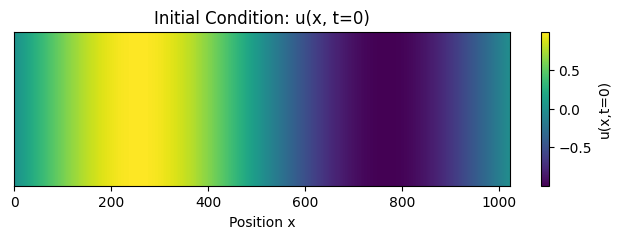

In [191]:
# iterate over each dataset:
# initial_field, full_trajectory, nu = next(iter(dataloader))
for initial_field, full_trajectory, nu in dataloader:
    # initial_field shape: (batch_size, N) — initial spatial fields
    # full_trajectory shape: (batch_size, T, N) — full solution trajectories
    # nu shape: (batch_size, 1) — viscosities for each sample

    # Example: your training or inference logic here
    print(f"Batch size: {initial_field.shape[0]}")
    print(f"Initial field shape: {initial_field.shape}")
    print(f"Full trajectory shape: {full_trajectory.shape}")
    print(f"Viscosity values: {nu.squeeze().tolist()}")


N = full_trajectory.shape[2] # no. of spatial points recorded at each time snapshot.
T = full_trajectory.shape[1] # no. of time snapshots.


# # TRUE TARGETS/LABELS:
targets = {}
for viscosity, dataset_tensor in zip(viscosities, datasets):
    # dataset_tensor shape (1, T, N)
    # Store all trajectories for this viscosity as target
    key = round(viscosity, 3) # round to 3.d.p
    targets[key] = dataset_tensor


# VISUALIZATION OF THE FIELD:
field_np = initial_field[0].numpy()

plt.figure(figsize=(8, 2))
plt.imshow(field_np[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='u(x,t=0)')
plt.xlabel('Position x')
plt.title(f'Initial Condition: u(x, t=0)')
plt.yticks([])
plt.show()


#### Extract local regions from field: create patches

* For each spatial position $i$, we want to extract the slide $[u_{i-r},...,u_i,...,u_{i+r}]$.

* $r$ is the patch radius (how many neighbours you consider from left and right side).

* We then pass this patch/region to the CNN controller to perform updates.

* Patch size: $2r +1$ (no. of points you take from spatial field).

* We create a 3D tensor `patches` storing the patch (neighbour points) for each spatial location in the field.

In [182]:
# Choose value of the patch radius r:
r = 1 

# Patch size: 
patch_size = 2 * r + 1

# Need to extend the field at the edges (add padding) so all patches have a full size: 2r + 1.
# Create a padded tensor by adding r points on both ends of the tensor, new size of tensor: N + 2r 
padded_field = nn.functional.pad(initial_field, (r, r), mode='replicate')  # shape (1, N + 2r)

# For each spatial point, we extract the local neighbours (patch) of size 2r + 1:
patches = padded_field.unfold(dimension = 1, size = patch_size, step = 1) # shape (1, N, 2r + 1)

# print(patches.shape)
batch_size = patches.shape[0]
patch_size = patches.shape[2]

#### CNN controller

* Construct CNN that acts as the controller to process each patch.

* Typical architecture: input layer of patch size, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.

* The CNN processes patches independently across the field.


In [183]:
# CNN controller definition:
class CNNController(nn.Module):
    def __init__(self, patch_size):
        super(CNNController, self).__init__()
        # First layer has the kernel size equal to the patch size (3 if r = 1).
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=patch_size, padding=0)
        self.activation1 = nn.Tanh()  # or nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=1)
        self.activation2 = nn.Tanh()
        self.output_layer = nn.Conv1d(in_channels=8, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        # x shape: (batch_size, 1, patch_size)
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.output_layer(x)
        return x  # shape: (batch_size, 1, 1) -> scalar output for each patch
    

    
# Create CNN controller for our NFTM:
cnn_controller = CNNController(patch_size) # r = 1

#### Read/Write head

* The controller reads patches, computes local updates, and writes these updates back into the corresponding local regions of the field.

* Reading: extract patches (local neighbourhoods) centered at each spatial position. These patches have shape `(batch_size, N, patch_size)`.

* Need to **reshape** patches to `(batch_size * N, 1, patch_size)`, to go as **input** into the CNN controller. This enables the CNN to process all patches in parallel as separate inputs in a batch.

* We treat each patch (local neighbours) as a separate 1D sample with 1 channel + length equal to patch_size.

* CNN **outputs** a **scalar value** per patch, with shape: `(batch_size * N, 1, 1)`.

* Need to **reshape** back to the field shape: `(batch_size,  N)`.

* Writing: updating the field.


In [184]:
# Reading: extract patches and reshape.
# Input for the CNN controller:
patches_input = patches.reshape(batch_size * N, 1, patch_size) # batch_size = 4

# Pass reshaped patches to the CNN controller and get updates for each patch:
patches_updates = cnn_controller(patches_input)
# Reshape outputs:
patches_updates = patches_updates.reshape(batch_size, N) # batch_size = 4

# Writing: update the spatial field with new values.
initial_field = initial_field + patches_updates


#### Loss Function

* A common choice for the cost function is the MSE: $$L_{MNE} = \frac{1}{N} \sum_{i = 1}^{N} \sum_{t = 1}^{T} (u_{i,t} - \hat u_{i,t})^2$$

* N = no. spatial points at each time snapshot.

* T = no. of time snapshots where solution is considered.

* $\hat u_{i,t}$ = NFTM's predicted velocity at spatial point $i$ and time $t$.

* $u_{i,t}$ = truth velocity at spatial point $i$ and time $t$.

* The error between predicted values and truth solutions from your training data at different time steps.

In [185]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

* We backpropagate the loss and update the CNN controller's weights using an optimizer.

    * Clear the gradients before backpropagation: `optimizer.zero_grad()`.

    * Compute gradients of the loss with respect to model parameters (backpropagation): `loss.backward()`.

    * Update the model parameters using the computed gradients: `optimizer.step()`.

* We can use the Adam optimizer among others.

In [186]:
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr = 0.001) # OPTIMIZER

#### Training Loop

Epoch 1/50, Cost: 0.039256
Epoch 2/50, Cost: 0.039256
Epoch 3/50, Cost: 0.039255
Epoch 4/50, Cost: 0.039254
Epoch 5/50, Cost: 0.039254
Epoch 6/50, Cost: 0.039253
Epoch 7/50, Cost: 0.039253
Epoch 8/50, Cost: 0.039253
Epoch 9/50, Cost: 0.039253
Epoch 10/50, Cost: 0.039253
Epoch 11/50, Cost: 0.039253
Epoch 12/50, Cost: 0.039253
Epoch 13/50, Cost: 0.039253
Epoch 14/50, Cost: 0.039253
Epoch 15/50, Cost: 0.039253
Epoch 16/50, Cost: 0.039253
Epoch 17/50, Cost: 0.039253
Epoch 18/50, Cost: 0.039253
Epoch 19/50, Cost: 0.039253
Epoch 20/50, Cost: 0.039253
Epoch 21/50, Cost: 0.039253
Epoch 22/50, Cost: 0.039253
Epoch 23/50, Cost: 0.039253
Epoch 24/50, Cost: 0.039253
Epoch 25/50, Cost: 0.039253
Epoch 26/50, Cost: 0.039253
Epoch 27/50, Cost: 0.039253
Epoch 28/50, Cost: 0.039253
Epoch 29/50, Cost: 0.039253
Epoch 30/50, Cost: 0.039253
Epoch 31/50, Cost: 0.039253
Epoch 32/50, Cost: 0.039253
Epoch 33/50, Cost: 0.039253
Epoch 34/50, Cost: 0.039253
Epoch 35/50, Cost: 0.039253
Epoch 36/50, Cost: 0.039253
E

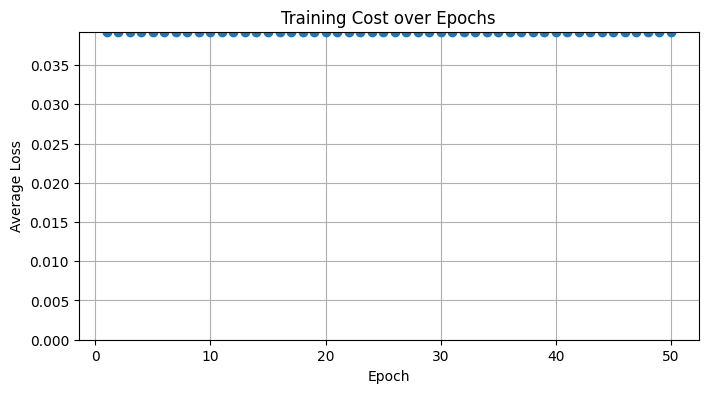

In [211]:
num_epochs = 50  # adjust as needed
epoch_losses = []  # list to store average loss per epoch

for epoch in range(num_epochs):
    total_loss = 0.0

    for initial_field, full_trajectory, nu in dataloader: # go through each batch (one for each viscosity value)
        optimizer.zero_grad()

        batch_size, N = initial_field.shape
        T = full_trajectory.shape[1]
        field = initial_field
        loss_over_time = 0.0

        # Rollout over all time steps from 1 to T-1
        for t in range(1, T):
            padded_field = torch.nn.functional.pad(field, (r, r), mode='replicate')
            patches = padded_field.unfold(1, patch_size, 1)
            patches_reshaped = patches.reshape(batch_size * N, 1, patch_size)

            outputs = cnn_controller(patches_reshaped).reshape(batch_size, N)
            field = outputs

            # Prepare targets batch-wise based on viscosities
            targets_t = torch.zeros_like(outputs)
            for i in range(batch_size):
                viscosity_value = round(nu[i].item(), 3) # round to 3.d.p
                target_trajectory = targets[viscosity_value].squeeze(0).to(outputs.device)  # (T, N)
                targets_t[i] = target_trajectory[t]

            loss = mse_loss(outputs, targets_t)
            loss_over_time += loss

        # Compute loss
        loss = mse_loss(outputs, targets_t)
        optimizer.zero_grad() # Clear the gradients before backpropagation.
        loss.backward() # compute gradients of the loss with respect to model parameters.
        optimizer.step() # Update model parameters using the computed gradients.
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Cost: {avg_loss:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Cost over Epochs')
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

In [212]:
def visualize_heatmap(field_pred, field_true, sample_idx=0):
    print(f"Visualizing solutions for viscosity = {nu[sample_idx].item():.4f}")

    pred = field_pred[sample_idx].cpu().detach().numpy()  # shape (T, N)
    true = field_true[sample_idx].cpu().detach().numpy()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(true, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='u(x,t) Ground Truth')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('True Trajectories')

    plt.subplot(1, 2, 2)
    plt.imshow(pred, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='u(x,t) Predicted')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('Predicted Trajectories')

    plt.tight_layout()
    plt.show()



In [210]:
# num_epochs = 30  # or however many epochs you want for evaluation

# for epoch in range(num_epochs):
#     cnn_controller.eval()
#     with torch.no_grad():
#         for initial_field, full_trajectory, nu in dataloader:
#             batch_size, N = initial_field.shape
#             T = full_trajectory.shape[1]
#             device = initial_field.device

#             predictions = torch.zeros((batch_size, T, N), device=device)
#             predictions[:, 0, :] = initial_field

#             field = initial_field

#             for t in range(1, T):
#                 padded_field = torch.nn.functional.pad(field, (r, r), mode='replicate')
#                 patches = padded_field.unfold(1, patch_size, 1)
#                 patches_reshaped = patches.reshape(batch_size * N, 1, patch_size)
#                 outputs = cnn_controller(patches_reshaped).reshape(batch_size, N)
#                 field = outputs
#                 predictions[:, t, :] = field

#             targets_batch = torch.zeros_like(predictions)
#             for i in range(batch_size):
#                 viscosity_value = round(nu[i].item(), 3)
#                 target_trajectory = targets[viscosity_value].squeeze(0).to(device)  # (T, N)
#                 targets_batch[i] = target_trajectory

#             print(f"Epoch {epoch+1}/{num_epochs}")
#             visualize_heatmap(predictions, targets_batch, sample_idx=0)
#             break  # visualize only first batch per epoch

#     cnn_controller.train()


Visualizing solutions for viscosity = 0.0100


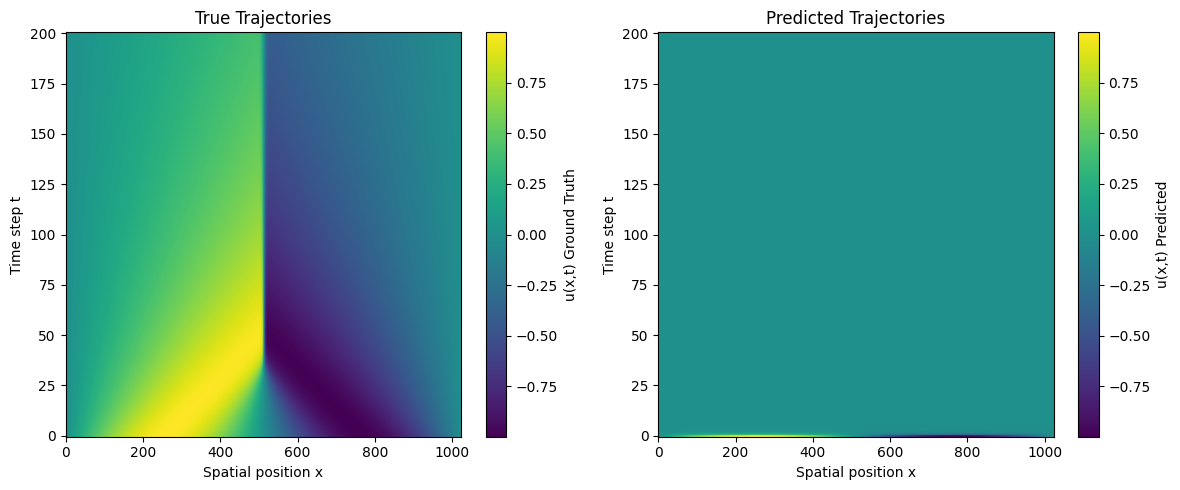

CNNController(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
  (activation1): Tanh()
  (conv2): Conv1d(8, 8, kernel_size=(1,), stride=(1,))
  (activation2): Tanh()
  (output_layer): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
)

In [213]:
# --- Final evaluation and visualization ---
cnn_controller.eval()
with torch.no_grad():
    for initial_field, full_trajectory, nu in dataloader:
        batch_size, N = initial_field.shape
        T = full_trajectory.shape[1]
        device = initial_field.device

        predictions = torch.zeros((batch_size, T, N), device=device)
        predictions[:, 0, :] = initial_field

        field = initial_field
        for t in range(1, T):
            padded_field = torch.nn.functional.pad(field, (r, r), mode='replicate')
            patches = padded_field.unfold(1, patch_size, 1)
            patches_reshaped = patches.reshape(batch_size * N, 1, patch_size)
            outputs = cnn_controller(patches_reshaped).reshape(batch_size, N)
            field = outputs
            predictions[:, t, :] = field

        targets_batch = torch.zeros_like(predictions)
        for i in range(batch_size):
            viscosity_value = round(nu[i].item(), 3)
            target_trajectory = targets[viscosity_value].squeeze(0).to(device)
            targets_batch[i] = target_trajectory

        visualize_heatmap(predictions, targets_batch, sample_idx=0)
        break  # visualize only the first batch

cnn_controller.train()


Summary of the Architecture:

* Input: 1D spatial field representing $u(x,t)$.

* Patch extraction: Sliding local neighborhoods of radius $r$.

* Controller: CNN processing each local patch.

* Update: Local field value updates returned by CNN.

* Iteration: Time-stepping loop applying CNN update repeatedly.

* Output: Predicted evolution of $u(x,t)$ over time.

This setup lets you build an end-to-end differentiable NFTM that learns local update rules via convolutional kernels, naturally capturing the physics of the 1D Burgers equation with your training data.